In [1]:
from pathlib import Path

import numpy as np
import arviz as az
import pymc as pm
import pandas as pd
import xarray as xr
import geopandas as gpd
import cufflinks as cf
import matplotlib.pyplot as plt
from libpysal.weights import Kernel
from pandas.plotting import scatter_matrix
from scipy.spatial import distance_matrix
from sklearn.cluster import KMeans

cf.go_offline()
DATA_DIR = Path("../data/processed")
MODEL_DIR = Path("../models")

data = gpd.read_file(DATA_DIR / "spatial_income_1880.gpkg")
data["is_old"] = data.is_old.astype(int)
pca_transformed = pd.read_csv(DATA_DIR / "pca_transformed.csv", index_col=0).drop(
    columns=["geometry"]
)
data = data.join(pca_transformed)
data = data.drop(index=data[data.population < 5].index).dropna().reset_index()
# W = Kernel.from_dataframe(data, fixed=True, bandwidth=150, function='quartic')
xy = np.array([data.geometry.x, data.geometry.y]).T
d = distance_matrix(xy, xy)
d_norm = d / d.max()
n = data.shape[0]

SEED = 42
N_CLUSTERS = len(data.group.unique())

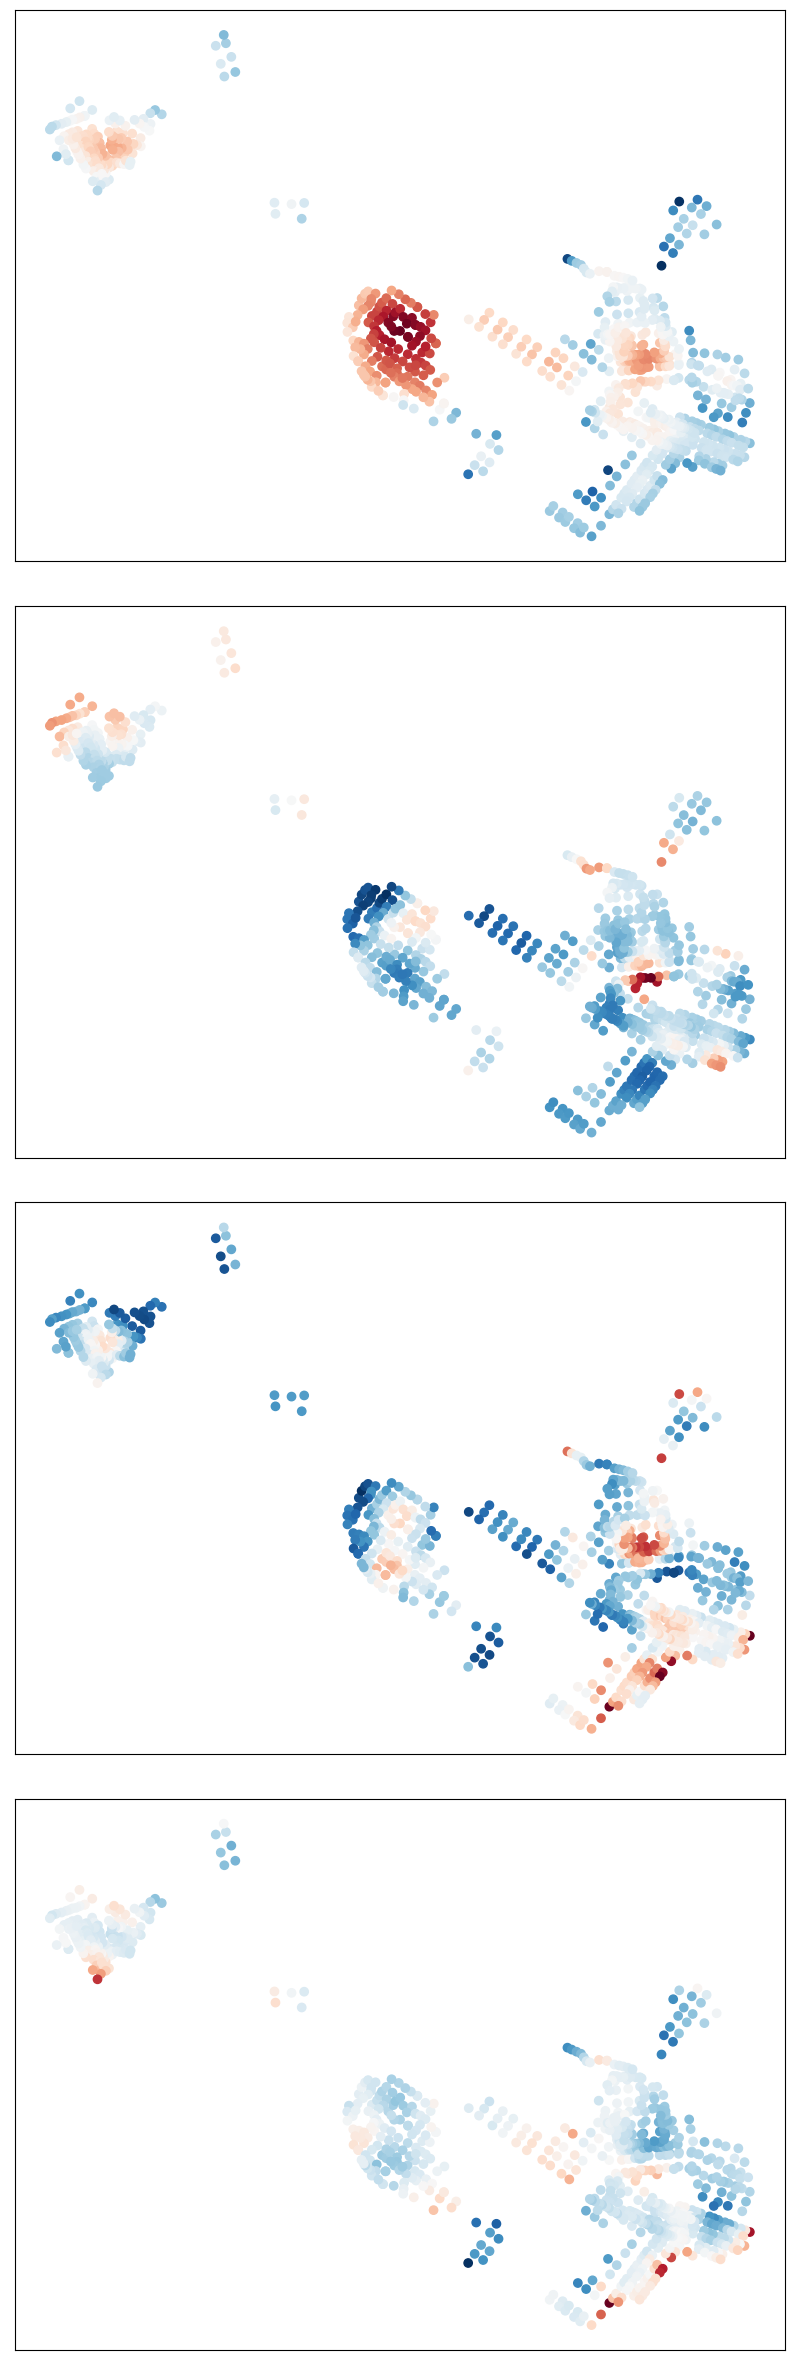

In [2]:
fig, (ax_1, ax_2, ax_3, ax_4) = plt.subplots(
    4, 1, figsize=(8, 24), subplot_kw={"xticks": [], "yticks": []}
)
data.plot(
    column="1",
    cmap="RdBu",
    ax=ax_1,
)
data.plot(
    column="2",
    cmap="RdBu_r",
    ax=ax_2,
)
data.plot(
    column="3",
    cmap="RdBu_r",
    ax=ax_3,
)
data.plot(
    column="4",
    cmap="RdBu_r",
    ax=ax_4,
)
fig.tight_layout()
plt.show()

In [3]:
with pm.Model() as model_1:
    W = pm.MutableData("W", -data["3"])

    β_P = pm.MvNormal(
        "β_P", np.array([0, 0]), np.array(np.diagflat([0.1, 0.1])), shape=2
    )

    μ_P = β_P[0] + β_P[1] * W
    σ_P = pm.Exponential("σ_P", 1)
    P = pm.Normal("P", mu=μ_P, sigma=σ_P, observed=-data["1"])

    β_O = pm.MvNormal(
        "β_O", np.array([0, 0, 0]), np.array(np.diagflat([0.1, 0.1, 0.1])), shape=3
    )

    μ_O = β_O[0] + β_O[1] * W + β_O[2] * μ_P
    σ_O = pm.Exponential("σ_O", 1)
    O = pm.Normal("O", mu=μ_O, sigma=σ_O, observed=data["2"])

    prior_1 = pm.sample_prior_predictive()
    posterior_1 = pm.sample(init="adapt_diag", return_inferencedata=True)
    posterior_prediction_1 = pm.sample_posterior_predictive(posterior_1)

Sampling: [O, P, β_O, β_P, σ_O, σ_P]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β_P, σ_P, β_O, σ_O]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Sampling: [O, P]


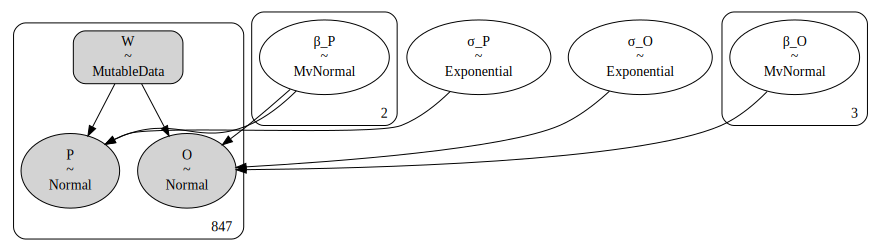

In [4]:
graph_1 = pm.model_to_graphviz(model_1)
graph_1

array([<AxesSubplot: xlabel='P / P'>, <AxesSubplot: xlabel='O / O'>],
      dtype=object)

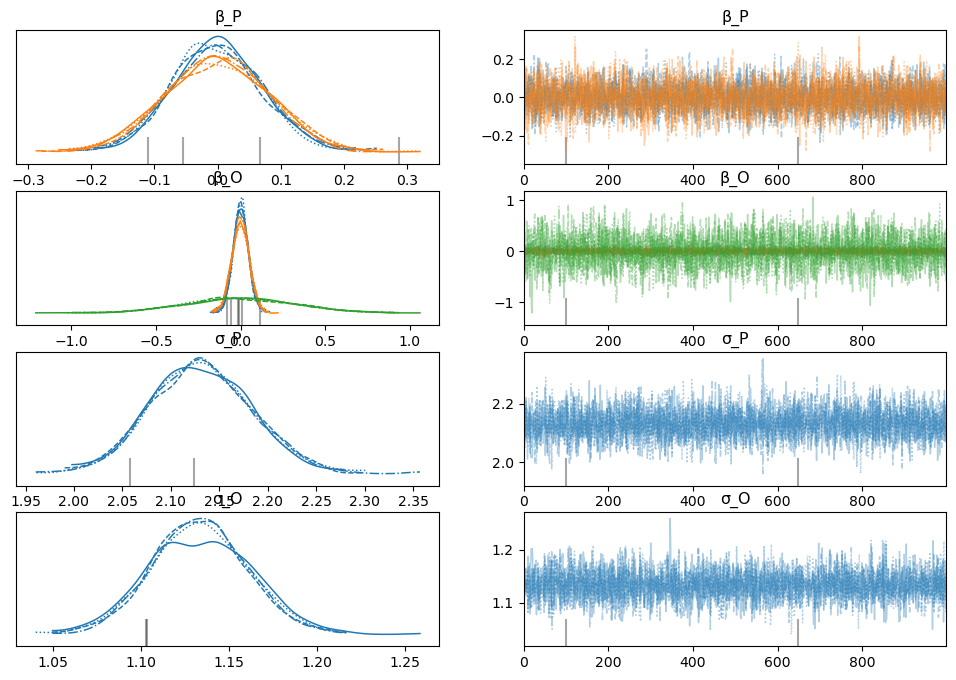

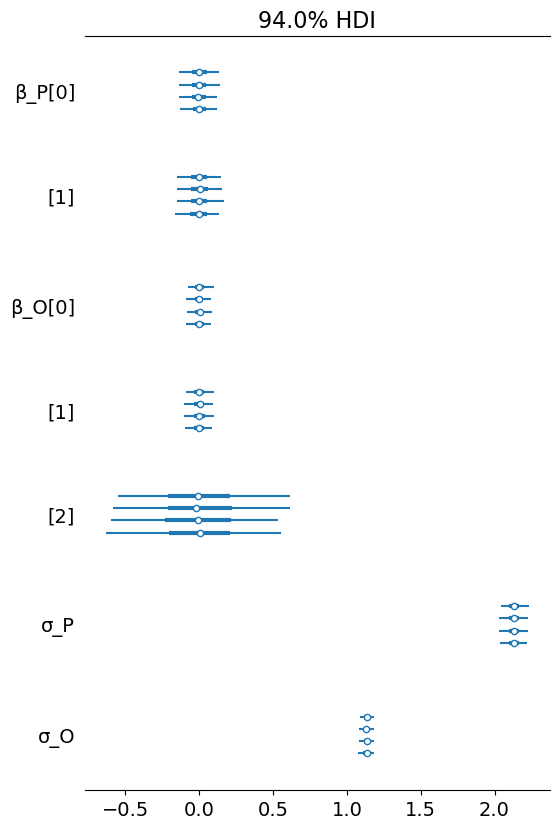

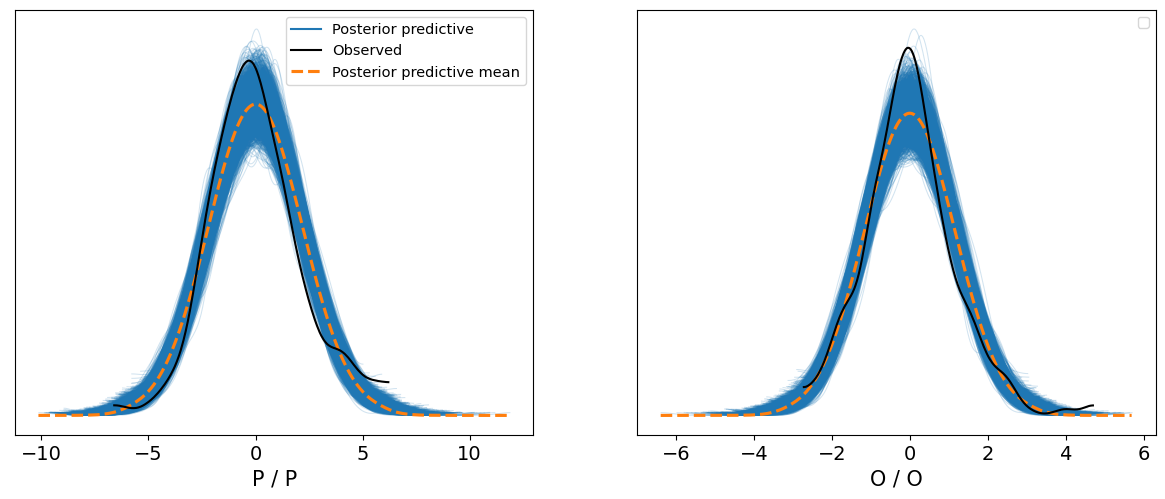

In [5]:
# az.plot_posterior(posterior_1)
az.plot_trace(posterior_1)
az.plot_forest(posterior_1, combined=False, hdi_prob=0.94)

az.plot_ppc(posterior_prediction_1)

# Clustering

In [6]:
cluster_colors = plt.get_cmap("tab20")
data.explore(
    column="group",
    categorical=True,
    cmap=cluster_colors,
    marker_kwds=dict(fill=True, radius=5),
    legend=True,
)

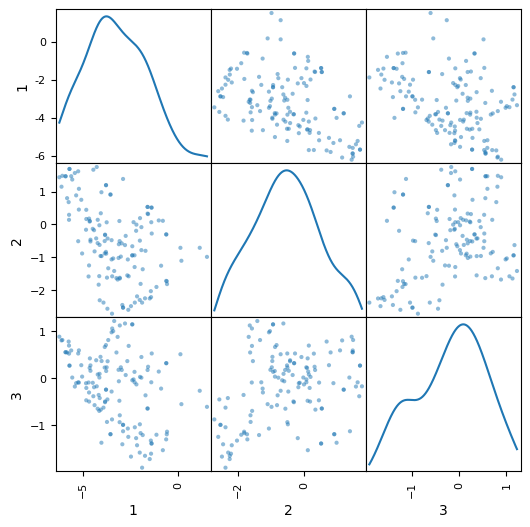

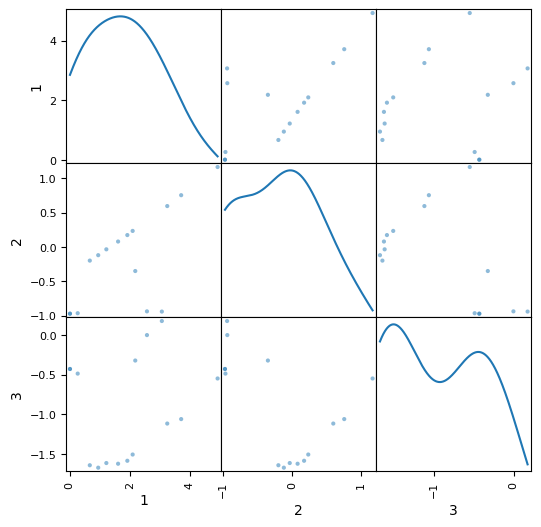

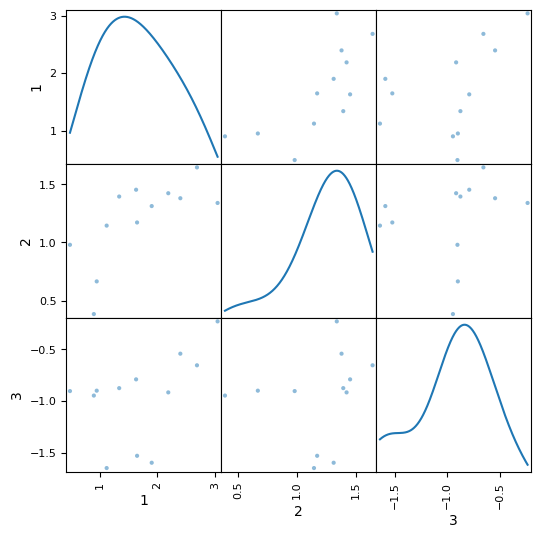

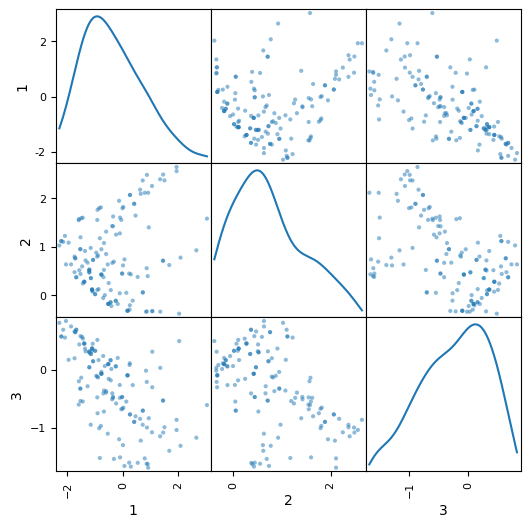

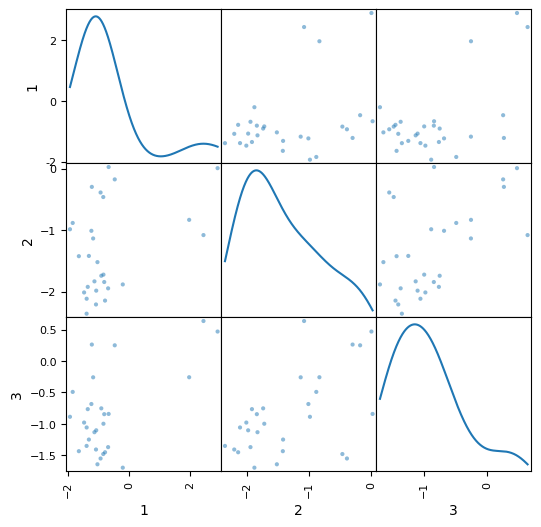

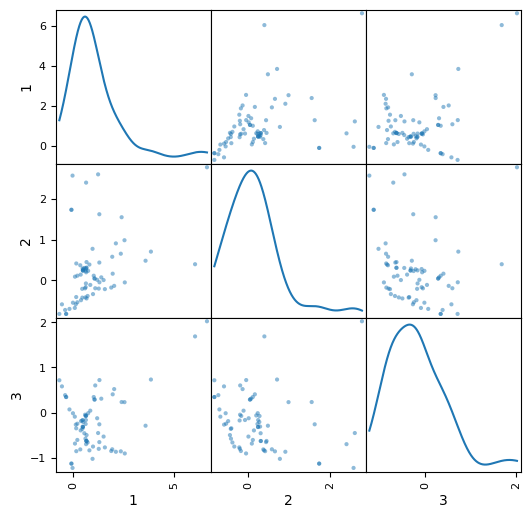

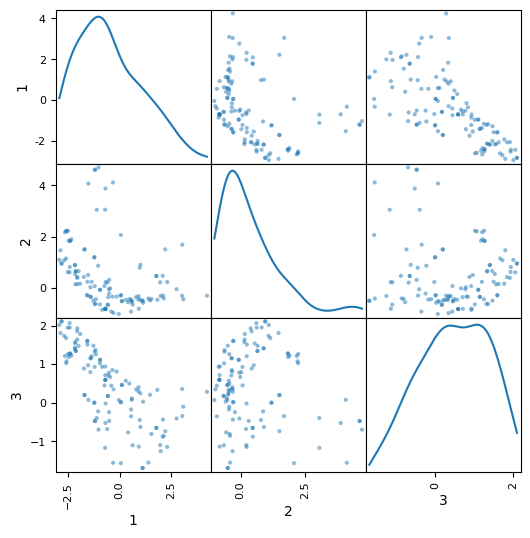

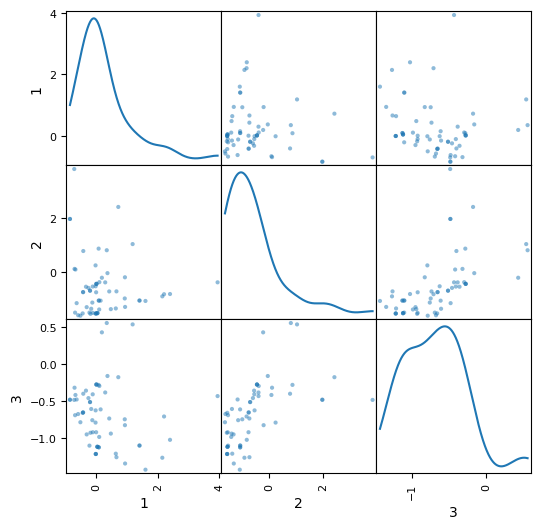

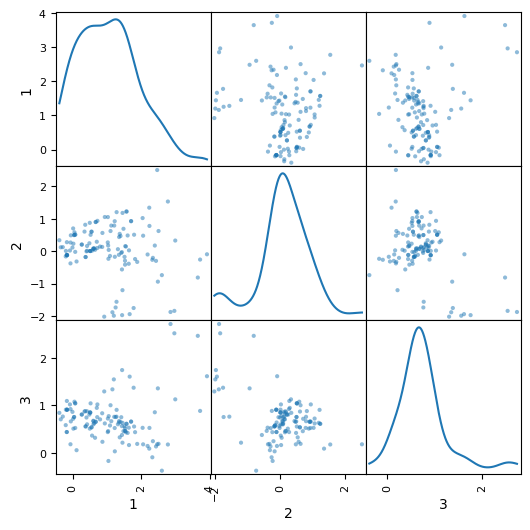

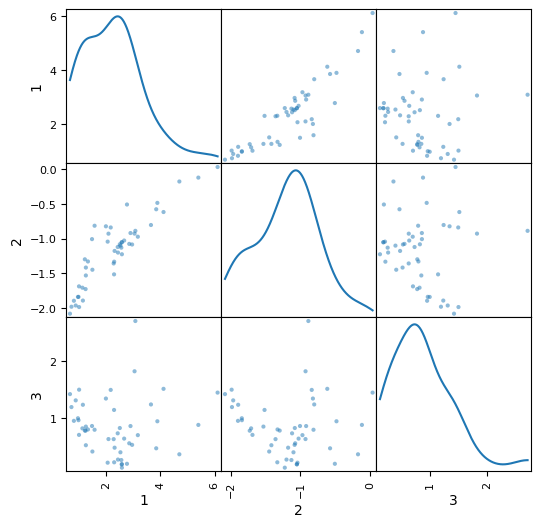

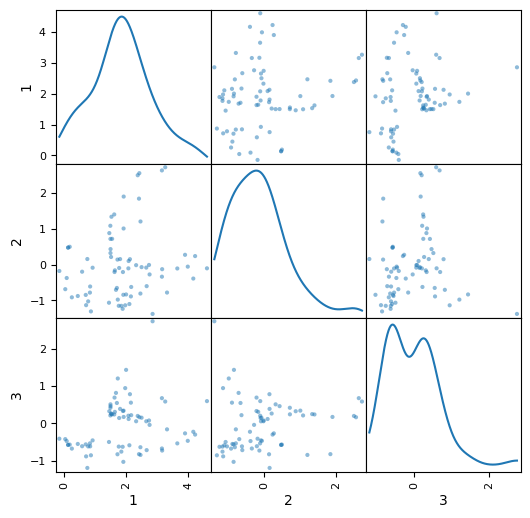

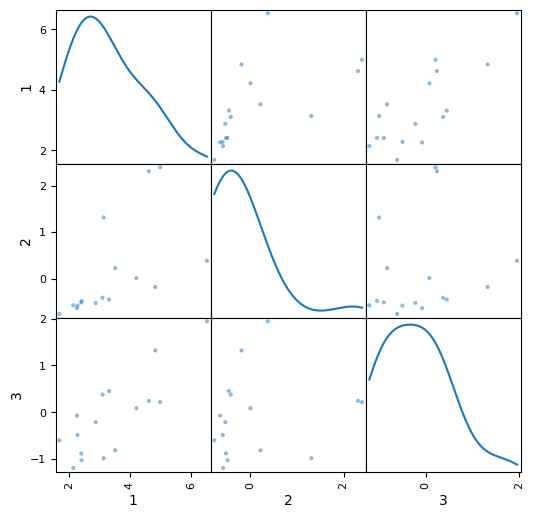

In [7]:
for i in data.group.unique():
    scatter_matrix(
        data.loc[data.group == i, ["1", "2", "3"]], diagonal="kde", figsize=(6, 6)
    )

# Final model with 12 geographical clusters (K-means)

$$ P_i \sim N(μ_{P,i}, σ_P), i = 0, 1, ... 846 $$
$$ O_i \sim N(μ_{O,i}, σ_O), i = 0, 1, ... 846 $$
$$ μ_{P,i} = [1 \; W]  β_{P,k[i]}, i = 0, 1, ... 846, k = 0, 1, ... 11 $$
$$ μ_{O,i} = [1 \; W]  β_{O,k[i]}, i = 0, 1, ... 846, k = 0, 1, ... 11 $$
$$ σ_P \sim Exp(1) $$
$$ σ_O \sim Exp(1) $$
$$ β_{P,k} \sim MvNormal \left( θ_P, \begin{bmatrix} 0.01 & 0 \\ 0 & 0.01 \end{bmatrix} \right), k = 0, 1, ... 11 $$
$$ β_{O,k} \sim MvNormal \left( θ_O, \begin{bmatrix} 0.01 & 0 \\ 0 & 0.01 \end{bmatrix} \right), k = 0, 1, ... 11 $$
$$ θ_{P} \sim MvNormal \left( \begin{bmatrix} 0 \\ 0 \end{bmatrix}, \begin{bmatrix} 0.1 & 0 \\ 0 & 0.1 \end{bmatrix} \right) $$
$$ θ_{O} \sim MvNormal \left( \begin{bmatrix} 0 \\ 0 \\ 0 \end{bmatrix}, \begin{bmatrix} 0.1 & 0 \\ 0 & 0.1 \end{bmatrix} \right) $$
where W is Component 3, i indicates the cadastral plot, and k[i] the cluster of the cadastral plot

In [8]:
with pm.Model() as model_2:
    W = pm.MutableData("W", -data["3"])
    idx = data.group

    θ_P = pm.MvNormal(
        "θ_P", np.array([0, 0]), np.array(np.diagflat([0.1, 0.1])), shape=2
    )
    θ_O = pm.MvNormal(
        "θ_O", np.array([0, 0]), np.array(np.diagflat([0.1, 0.1])), shape=2
    )

    β_P = pm.MvNormal(
        "β_P", θ_P, np.array(np.diagflat([0.01, 0.01])), shape=(N_CLUSTERS, 2)
    )
    β_O = pm.MvNormal(
        "β_O", θ_O, np.array(np.diagflat([0.01, 0.01])), shape=(N_CLUSTERS, 2)
    )

    μ_P = β_P[idx, 0] + β_P[idx, 1] * W
    σ_P = pm.Exponential("σ_P", 1)
    P = pm.Normal("P", mu=μ_P, sigma=σ_P, observed=-data["1"])

    μ_O = β_O[idx, 0] + β_O[idx, 1] * W
    σ_O = pm.Exponential("σ_O", 1)
    O = pm.Normal("O", mu=μ_O, sigma=σ_O, observed=data["2"])

    prior_2 = pm.sample_prior_predictive(samples=100, random_seed=SEED)
    posterior_2 = pm.sample(
        draws=1000,
        tune=1000,
        init="adapt_diag",
        return_inferencedata=True,
        target_accept=0.9,
        random_seed=SEED,
    )
    posterior_prediction_2 = pm.sample_posterior_predictive(
        posterior_2, random_seed=SEED
    )

Sampling: [O, P, β_O, β_P, θ_O, θ_P, σ_O, σ_P]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ_P, θ_O, β_P, β_O, σ_P, σ_O]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 633 seconds.
Sampling: [O, P]


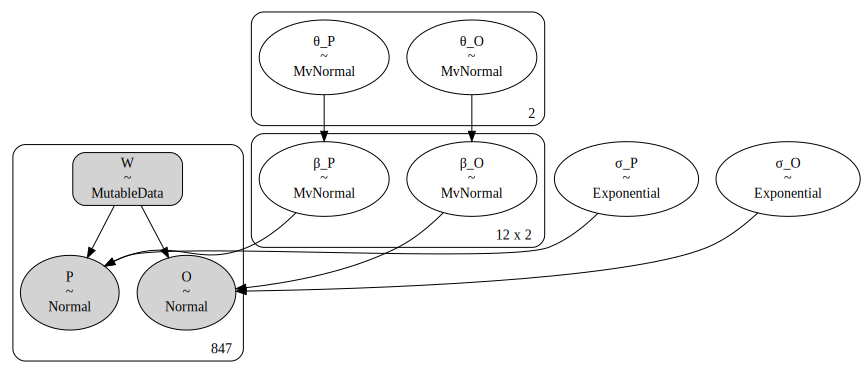

In [9]:
graph_2 = pm.model_to_graphviz(model_2)
graph_2

## Prior predictive check

Text(0, 0.5, 'μ_P')

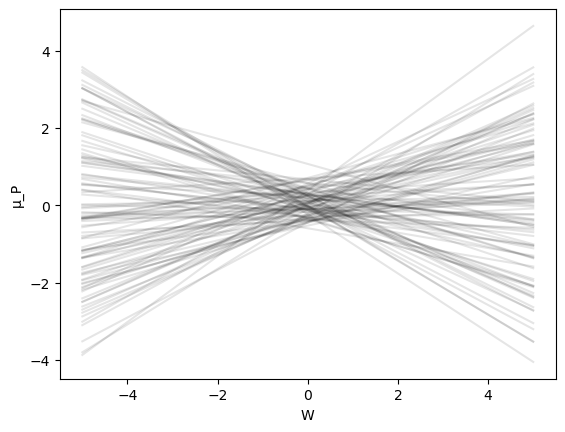

In [10]:
prior = prior_2["prior"]
x = xr.DataArray(np.linspace(-5, 5, 100), dims=["x"])
y = prior["β_P"][:, :, 0, 0] + prior["β_P"][:, :, 0, 1] * x
_, ax = plt.subplots()
ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.1)
ax.set_xlabel("W")
ax.set_ylabel("μ_P")

Text(0, 0.5, 'μ_O')

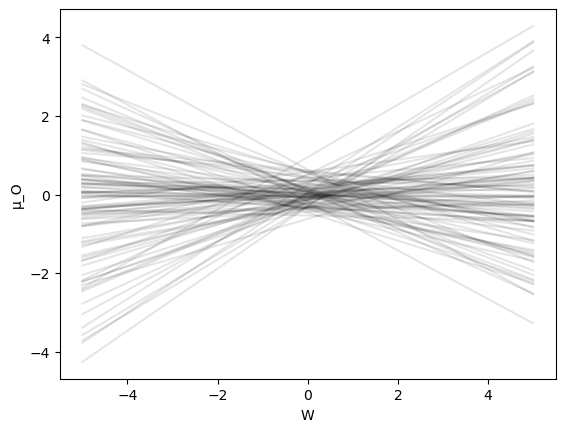

In [11]:
x = xr.DataArray(np.linspace(-5, 5, 100), dims=["x"])
y = prior["β_O"][:, :, 0, 0] + prior["β_O"][:, :, 0, 1] * x
_, ax = plt.subplots()
ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.1)
ax.set_xlabel("W")
ax.set_ylabel("μ_O")

## Posterior predictive check

array([<AxesSubplot: xlabel='P / P'>, <AxesSubplot: xlabel='O / O'>],
      dtype=object)

/home/antth/.local/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/home/antth/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



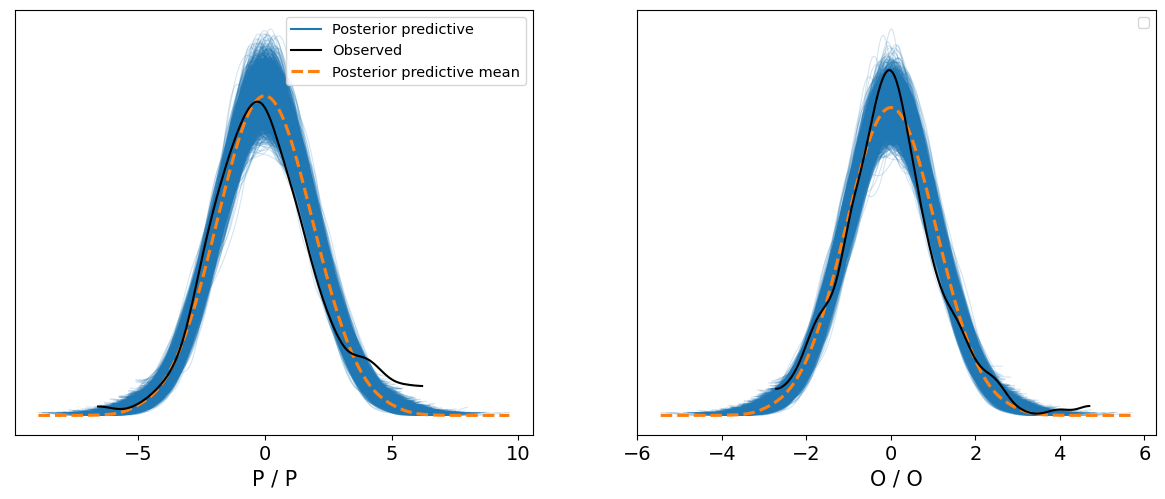

In [12]:
az.plot_ppc(posterior_prediction_2)

## Trace plots

In [13]:
az.summary(posterior_2, hdi_prob=0.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
θ_P[0]     -0.086  0.068    -0.221      0.042      0.002    0.001    1399.0   
θ_P[1]     -0.048  0.079    -0.200      0.105      0.002    0.002    1008.0   
θ_O[0]     -0.018  0.049    -0.116      0.072      0.001    0.001    2584.0   
θ_O[1]      0.003  0.055    -0.108      0.107      0.001    0.001    1809.0   
β_P[0, 0]   0.078  0.096    -0.104      0.280      0.002    0.001    3674.0   
β_P[0, 1]  -0.172  0.115    -0.397      0.055      0.002    0.002    2449.0   
β_P[1, 0]  -0.097  0.107    -0.301      0.109      0.002    0.001    2987.0   
β_P[1, 1]  -0.067  0.120    -0.306      0.167      0.003    0.002    2012.0   
β_P[2, 0]   0.926  0.103     0.721      1.119      0.002    0.001    4178.0   
β_P[2, 1]  -0.052  0.109    -0.273      0.150      0.002    0.002    2475.0   
β_P[3, 0]  -0.254  0.108    -0.477     -0.057      0.002    0.001    3459.0   
β_P[3, 1]  -0.007  0.120    -0.242      0.230      0.003    0.002    2066.0   
β_P[4, 0]   0.031  0.099    -0.163      0.222      0.002    0.001    3451.0   
β_P[4, 1]  -0.385  0.102    -0.592     -0.191      0.002    0.002    2268.0   
β_P[5, 0]  -0.425  0.108    -0.619     -0.201      0.002    0.001    3387.0   
β_P[5, 1]  -0.027  0.120    -0.259      0.204      0.003    0.002    2059.0   
β_P[6, 0]  -0.023  0.116    -0.251      0.198      0.002    0.002    3235.0   
β_P[6, 1]   0.041  0.120    -0.191      0.269      0.003    0.002    2088.0   
β_P[7, 0]  -0.368  0.115    -0.589     -0.141      0.002    0.001    3295.0   
β_P[7, 1]   0.180  0.119    -0.049      0.410      0.003    0.002    2258.0   
β_P[8, 0]  -0.248  0.119    -0.476     -0.009      0.002    0.002    2881.0   
β_P[8, 1]  -0.020  0.122    -0.244      0.225      0.003    0.002    2295.0   
β_P[9, 0]  -0.141  0.120    -0.375      0.090      0.002    0.002    2929.0   
β_P[9, 1]  -0.096  0.126    -0.341      0.144      0.003    0.002    2509.0   
β_P[10, 0] -0.162  0.119    -0.391      0.073      0.002    0.002    3171.0   
β_P[10, 1] -0.110  0.124    -0.329      0.149      0.003    0.002    1952.0   
β_P[11, 0] -0.339  0.102    -0.515     -0.120      0.002    0.001    3259.0   
β_P[11, 1]  0.137  0.113    -0.067      0.372      0.002    0.002    2476.0   
β_O[0, 0]   0.402  0.068     0.278      0.542      0.001    0.001    5321.0   
β_O[0, 1]   0.310  0.085     0.147      0.472      0.001    0.001    4569.0   
β_O[1, 0]  -0.181  0.089    -0.345     -0.003      0.001    0.001    5403.0   
β_O[1, 1]  -0.247  0.099    -0.444     -0.059      0.002    0.001    3754.0   
β_O[2, 0]  -0.278  0.069    -0.411     -0.140      0.001    0.001    6458.0   
β_O[2, 1]  -0.248  0.080    -0.400     -0.092      0.001    0.001    4451.0   
β_O[3, 0]   0.086  0.080    -0.077      0.242      0.001    0.001    5773.0   
β_O[3, 1]   0.057  0.099    -0.132      0.256      0.001    0.001    4780.0   
β_O[4, 0]   0.227  0.071     0.083      0.359      0.001    0.001    6405.0   
β_O[4, 1]   0.005  0.069    -0.124      0.143      0.001    0.001    5423.0   
β_O[5, 0]  -0.014  0.079    -0.163      0.145      0.001    0.001    6953.0   
β_O[5, 1]  -0.045  0.094    -0.221      0.142      0.002    0.001    3699.0   
β_O[6, 0]  -0.263  0.097    -0.451     -0.071      0.001    0.001    4942.0   
β_O[6, 1]  -0.251  0.100    -0.452     -0.060      0.002    0.001    4285.0   
β_O[7, 0]  -0.335  0.094    -0.530     -0.160      0.001    0.001    5093.0   
β_O[7, 1]   0.249  0.096     0.057      0.433      0.001    0.001    4246.0   
β_O[8, 0]  -0.002  0.103    -0.196      0.203      0.001    0.002    5687.0   
β_O[8, 1]  -0.019  0.108    -0.226      0.191      0.002    0.002    4952.0   
β_O[9, 0]   0.104  0.102    -0.100      0.297      0.001    0.001    5036.0   
β_O[9, 1]   0.114  0.106    -0.088      0.322      0.002    0.001    4476.0   
β_O[10, 0] -0.039  0.101    -0.229      0.160      0.001    0.001    5175.0   
β_O[10, 1]  0.019  0.104    -0.177      0.227      0.002    0.0

array([<AxesSubplot: title={'center': '95.0% HDI'}>], dtype=object)

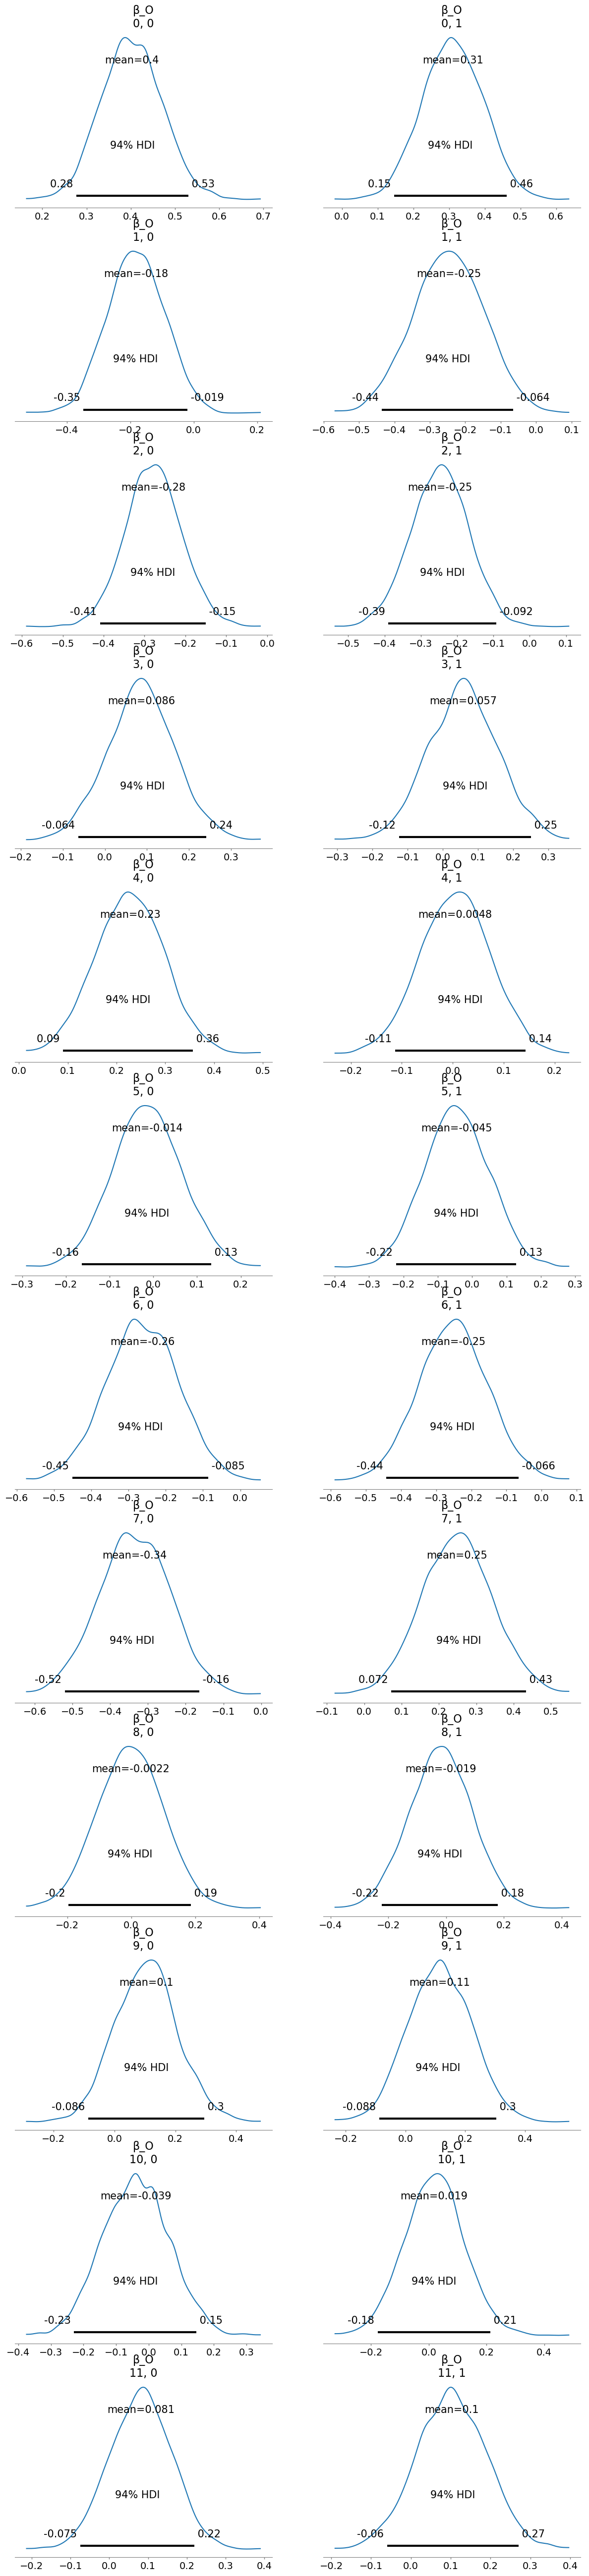

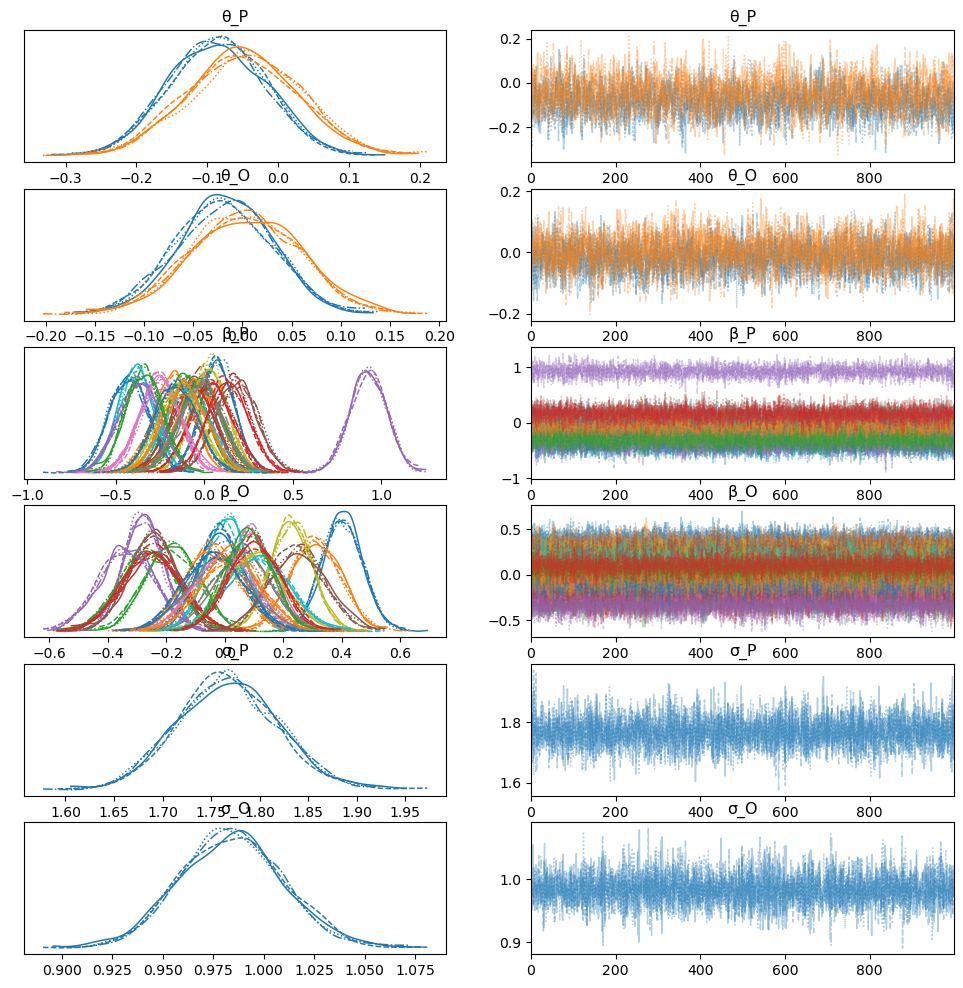

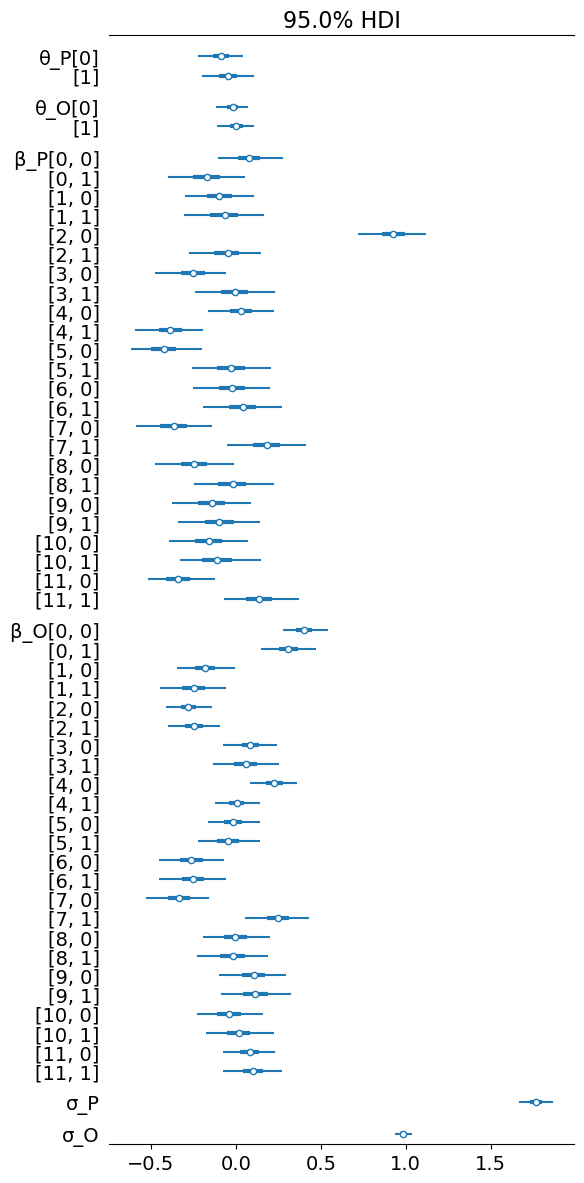

In [15]:
az.plot_posterior(posterior_2, var_names="β_O", grid=(12, 2))
az.plot_trace(posterior_2)
az.plot_forest(posterior_2, combined=True, hdi_prob=0.95)